In [1]:
import numpy as np
from itertools import chain
import random
from os.path import join

from keras.layers import Conv2D
from keras.models import Model
from keras import backend as K

from data import DatasetReader
from data import PATH_ABBYY_DATASET, PATH_BARCODES_DATASET, PATH_DUBSKA_MATRIX_DATASET
from data import PATH_DUBSKA_QRCODE_DATASET, PATH_SOEROES_DATASET
from models import DarknetModel

from utils.io import read_image
from utils.paths import PATH_PROJECT
from utils.image import resize_image

Using TensorFlow backend.


In [2]:
class Args:
    def __init__(self):
        self.train = True


args = Args()

In [3]:
path_artefacts = PATH_PROJECT
path_weights = join(path_artefacts, 'weights_detector')

In [4]:
BATCH_SIZE = 1
IMAGE_SHAPE = (3, None, None)
EPOCHS = 30
TRAIN_PERCENT = 0.9

In [5]:
K.set_image_data_format('channels_first')
feature_extractor = DarknetModel(IMAGE_SHAPE, use_dropout=True, filter_counts=[60, 100, 140])
DOWNSAMPLE_FACTOR = feature_extractor.get_downsample_factor()
print(f'Downsample factor: {DOWNSAMPLE_FACTOR}')

Downsample factor: 8


In [6]:
def create_ground_truth_image(shape, markup):
    image = np.zeros(shape)
    for corner in markup:
        points = np.array(corner['pts']) // DOWNSAMPLE_FACTOR
        for point in points:
            if shape[1] <= point[0] or shape[2] <= point[1]:
                raise ValueError('Point exceeds image bounds')
            image[0, point[0], point[1]] = 1
    return image


def generate_data(paths, datasets, randomize=True, shrink_size=256):
    while True:
        indices = list(range(len(paths)))
        if randomize:
            random.shuffle(indices)
        for path_idx in indices:
            path, dataset_idx = paths[path_idx]
            dataset = datasets[dataset_idx]
            image_id = dataset.get_image_id(path)
            markup = dataset.get_markup()[image_id]
            image = read_image(path)
            shrink_factor = max(image.shape[1] // shrink_size, image.shape[2] // shrink_size)
            if shrink_factor > 1:
                shrink_factor = 1.0 / shrink_factor
                image = resize_image(image, fx=shrink_factor, fy=shrink_factor)
            try:
                ground_truth = create_ground_truth_image((1,
                                                          image.shape[1] // DOWNSAMPLE_FACTOR,
                                                          image.shape[2] // DOWNSAMPLE_FACTOR), markup)
            except ValueError:
                continue
            yield np.array([image]), np.array([ground_truth])

In [7]:
datasets = [DatasetReader(path) for path in [PATH_SOEROES_DATASET,
                                             PATH_DUBSKA_QRCODE_DATASET,
                                             PATH_DUBSKA_MATRIX_DATASET,
                                             PATH_BARCODES_DATASET,
                                             PATH_ABBYY_DATASET]]
paths = [[(path, idx) for path in dataset.get_paths()]
         for idx, dataset in enumerate(datasets)]
paths = list(chain(*paths))

In [8]:
paths_train = random.sample(paths, int(TRAIN_PERCENT * len(paths)))
paths_test = list(set(paths) - set(paths_train))

batches_train = generate_data(paths_train, datasets)
batches_test = generate_data(paths_test, datasets)

In [9]:
# from utils.visualization import show_image
# 
# gen = batches_train
# image, gt = next(gen)
# print(image.shape)
# print(gt.shape)
# 
# show_image(image[0])
# show_image(gt[0])

In [10]:
feature_extractor = feature_extractor.get_model()
x = feature_extractor.output
x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
detector = Model(inputs=[feature_extractor.input], outputs=[x])
detector.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, None, None)    280       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, None, None)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, None, None)   10920     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 120, None, None)   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, None, None)    7260      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, None, None)    0         
__________

In [11]:
if args.train:
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    
    if args.train:
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            ModelCheckpoint(path_weights, monitor='val_loss', period=5, save_best_only=True)
            #EarlyStopping(monitor='val_loss', patience=25, verbose=1)
        ]
        detector.compile(loss='binary_crossentropy', optimizer='adam')
        history = detector.fit_generator(batches_train, steps_per_epoch=len(paths_train) // BATCH_SIZE // 4,
                                         validation_data=batches_test, validation_steps=len(paths_test) // BATCH_SIZE,
                                         epochs=EPOCHS, callbacks=callbacks)
        detector.save_weights(path_weights)
detector.load_weights(path_weights)

Epoch 1/30
346/346 [==============================] - 29s 85ms/step - loss: 0.0437 - val_loss: 0.0128
Epoch 2/30
346/346 [==============================] - 29s 84ms/step - loss: 0.0132 - val_loss: 0.0206
Epoch 3/30
346/346 [==============================] - 24s 70ms/step - loss: 0.0159 - val_loss: 0.0100
Epoch 4/30
346/346 [==============================] - 22s 62ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 5/30
346/346 [==============================] - 30s 86ms/step - loss: 0.0081 - val_loss: 0.0106
Epoch 6/30
346/346 [==============================] - 22s 64ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 7/30
346/346 [==============================] - 26s 76ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 8/30
346/346 [==============================] - 22s 65ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/30
346/346 [==============================] - 35s 101ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 10/30
346/346 [==============================] - 23s 65ms/step - loss: 0.00

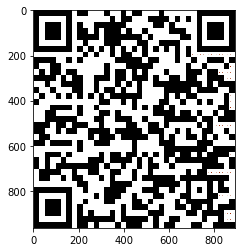

[[[  1.32008204e-02   6.77196681e-03   2.94621708e-03 ...,   4.15653037e-03
     2.27718540e-02   8.65325425e-03]
  [  4.79751825e-03   1.05978642e-03   3.37102043e-04 ...,   4.26088431e-04
     4.70427377e-03   1.77227345e-03]
  [  1.14754969e-02   1.43132766e-03   4.13813395e-04 ...,   9.50460148e-04
     8.02066550e-03   1.04719598e-03]
  ..., 
  [  1.04060546e-02   1.11228577e-03   8.22163012e-04 ...,   8.75217756e-06
     6.73244707e-04   3.07009293e-04]
  [  1.75058097e-02   3.11824982e-03   8.32491787e-04 ...,   2.51409627e-04
     4.08355263e-04   3.83642007e-04]
  [  3.39336693e-02   2.77211238e-03   7.58190872e-04 ...,   7.78981484e-04
     2.86297803e-03   5.32849412e-03]]]


In [33]:
import numpy as np
from utils.io import read_image
from utils.visualization import show_image


path = r'D:\My Docs\qr.png'
image = read_image(path)
show_image(image)

res = detector.predict(np.array([image]))[0]
print(res)

[[[False False False ..., False False False]
  [False False False ..., False False False]
  [False False False ..., False False False]
  ..., 
  [False False False ..., False False False]
  [False False False ..., False False False]
  [False False False ..., False False False]]]
6
(0, 6, 78)


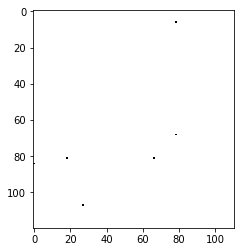

In [36]:
thresh = 0.5
mask = np.unravel_index(np.argmax((res > thresh)), res.shape)
print(res > thresh)
print(np.count_nonzero(res > thresh))
print(mask)
show_image((res > thresh).astype(np.int))